<a href="https://colab.research.google.com/github/ArdaSug/DSA210PROJECT/blob/main/DSA210PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yeni Bölüm

In [ ]:
total_games = [0, 0, 0, 0, 0]  # Indices correspond to months [5, 6, 8, 9, 10]
improvements = [0, 0, 0, 0, 0]


In [ ]:
import requests
import pandas as pd
from collections import Counter, defaultdict
import re
import matplotlib.pyplot as plt

month_input = input("Enter the month in numeric form (5,6,8,9 or 10): ").strip()
month_str = f"{int(month_input):02d}"  # Ensures two-digit format, e.g. '6' -> '06'


url = f"https://api.chess.com/pub/player/xreadytodayalex/games/2024/{month_str}"


headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}


opponent_country_cache = {}


def fetch_country_name(country_url):
    if country_url in opponent_country_cache:
        return opponent_country_cache[country_url]

    response = requests.get(country_url, headers=headers)
    if response.status_code == 200:
        country_name = response.json().get("name", "Unknown Country")
        opponent_country_cache[country_url] = country_name
        return country_name
    opponent_country_cache[country_url] = "Unknown Country"
    return "Unknown Country"


def fetch_opponent_country(player_url):
    if player_url in opponent_country_cache:
        return opponent_country_cache[player_url]

    response = requests.get(player_url, headers=headers)
    if response.status_code == 200:
        player_data = response.json()
        country_url = player_data.get("country", "")
        if country_url:
            return fetch_country_name(country_url)
    opponent_country_cache[player_url] = "Unknown Country"
    return "Unknown Country"


def clean_opening_name(opening_name):
    words = re.findall(r'\w+', opening_name)  # Extract words
    if len(words) >= 2:
        if words[0].lower() == "van" and words[1].lower() == "t":
            return "Van 't Kruijs"
        return ' '.join(words[:2])  # First two words
    return opening_name  # Fallback

# Main Script
response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    games = data.get("games", [])
    df = pd.DataFrame(games)


    filtered_games = df[(df["time_class"] == "rapid") & (df["rated"] == True)].reset_index(drop=True)


    first_game = filtered_games.iloc[0] if not filtered_games.empty else None
    last_game = filtered_games.iloc[-1] if not filtered_games.empty else None

    if first_game is not None and last_game is not None:
        first_rating = first_game['white']['rating'] if first_game['white']['username'] == "XREADYTODAYALEX" else first_game['black']['rating']
        last_rating = last_game['white']['rating'] if last_game['white']['username'] == "XREADYTODAYALEX" else last_game['black']['rating']
    else:
        first_rating = last_rating = "N/A"


    wins = 0
    losses = 0
    draws = 0
    played_as_white = 0
    played_as_black = 0
    openings_defenses_used = Counter()
    opponent_countries = Counter()
    opening_accuracies = defaultdict(float)


    total_white_accuracy = 0
    total_black_accuracy = 0


    for i, row in filtered_games.iterrows():

        white_player = row['white']['username']
        black_player = row['black']['username']
        result_white = row['white']['result']
        result_black = row['black']['result']
        played_as = "White" if white_player == "XREADYTODAYALEX" else "Black"


        opponent_username = black_player if played_as == "White" else white_player
        opponent_id_url = row['black']['@id'] if played_as == "White" else row['white']['@id']
        opponent_country = fetch_opponent_country(opponent_id_url)


        opponent_countries[opponent_country] += 1


        raw_opening = row.get('eco', 'Unknown Opening').split("/")[-1]
        opening_name_cleaned = clean_opening_name(raw_opening)


        if result_white == "win" and white_player == "XREADYTODAYALEX":
            winner = "XREADYTODAYALEX"
            wins += 1
        elif result_black == "win" and black_player == "XREADYTODAYALEX":
            winner = "XREADYTODAYALEX"
            wins += 1
        elif result_white in ["repetition", "agreed", "insufficient", "stalemate", "timevsinsufficient"] or \
             result_black in ["repetition", "agreed", "insufficient", "stalemate", "timevsinsufficient"]:
            winner = "Draw"
            draws += 1
        else:
            winner = opponent_username
            losses += 1


        openings_defenses_used[opening_name_cleaned] += 1


        if played_as == "White":
            opening_accuracies[opening_name_cleaned] += row['accuracies']['white']
            total_white_accuracy += row['accuracies']['white']
        else:
            opening_accuracies[opening_name_cleaned] += row['accuracies']['black']
            total_black_accuracy += row['accuracies']['black']

        # Track played as white or black
        if played_as == "White":
            played_as_white += 1
        else:
            played_as_black += 1

    # Calculate average accuracies
    avg_white_accuracy = total_white_accuracy / played_as_white if played_as_white > 0 else 0
    avg_black_accuracy = total_black_accuracy / played_as_black if played_as_black > 0 else 0
else:
    print(f"Error occurred! HTTP Status Code: {response.status_code}")


Enter the month in numeric form (5,6,8,9 or 10): 5


In [ ]:
 # Print summary results
print("Summary Results:")
print(" ")
print(f"First Rating in the Month (Rapid): {first_rating}")
print(f"Last Rating in the Month (Rapid): {last_rating}")
print(f"Improvement: {(last_rating - first_rating)}")
print("")
print(f"Total Games Played as White: {played_as_white}")
print(f"Total Games Played as Black: {played_as_black}")
print(f"Total Games Played: {(played_as_black + played_as_white)}")
print("")

Summary Results:
 
First Rating in the Month (Rapid): 589
Last Rating in the Month (Rapid): 813
Improvement: 224

Total Games Played as White: 110
Total Games Played as Black: 112
Total Games Played: 222



Total Wins by XREADYTODAYALEX: 117
Total Losses by XREADYTODAYALEX: 97
Total Draws: 8



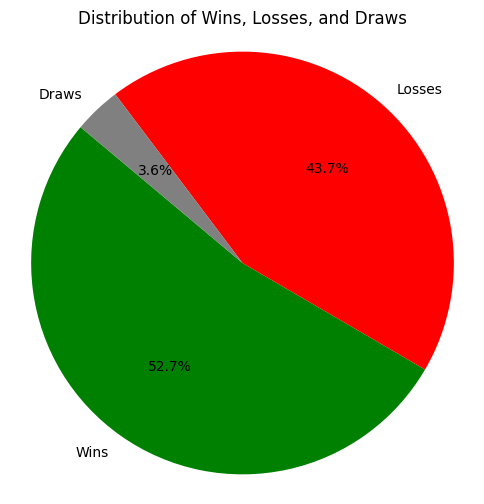

In [ ]:
print(f"Total Wins by XREADYTODAYALEX: {wins}")
print(f"Total Losses by XREADYTODAYALEX: {losses}")
print(f"Total Draws: {draws}")
print("")


labels = ['Wins', 'Losses', 'Draws']
sizes = [wins, losses, draws]
colors = ['green', 'red', 'gray']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Wins, Losses, and Draws')
plt.axis('equal')
plt.show()



Openings/Defenses Played More Than 5 Times (With Average Accuracy):
   Giuoco Piano: 30, Avg Accuracy: 73.33
   Kings Pawn: 19, Avg Accuracy: 69.32
   Four Knights: 15, Avg Accuracy: 72.58
   Queens Pawn: 19, Avg Accuracy: 72.15
   Ruy Lopez: 13, Avg Accuracy: 78.52
   Italian Game: 35, Avg Accuracy: 72.12
   Caro Kann: 7, Avg Accuracy: 73.80
   Sicilian Defense: 9, Avg Accuracy: 74.53



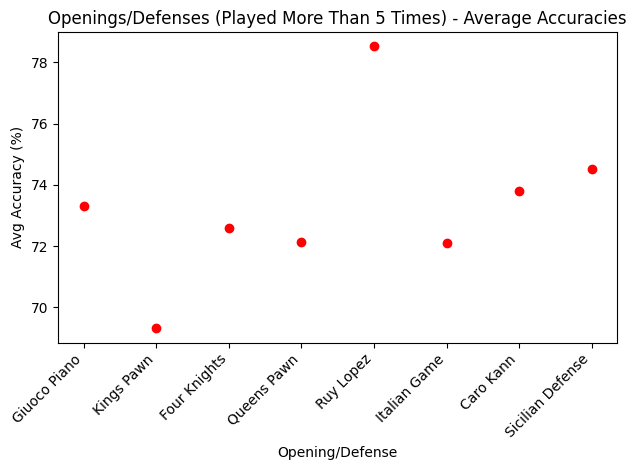

In [ ]:
print("")


print("\nOpenings/Defenses Played More Than 5 Times (With Average Accuracy):")
openings_more_than_5 = []
accuracies_more_than_5 = []
for opening, count in openings_defenses_used.items():
    if count > 5:
        avg_accuracy = opening_accuracies[opening] / count
        print(f"   {opening}: {count}, Avg Accuracy: {avg_accuracy:.2f}")

        openings_more_than_5.append(opening)
        accuracies_more_than_5.append(avg_accuracy)
print("")

if openings_more_than_5:
    x_positions = range(len(openings_more_than_5))
    plt.scatter(x_positions, accuracies_more_than_5, color='red')
    plt.xticks(x_positions, openings_more_than_5, rotation=45, ha='right')
    plt.title("Openings/Defenses (Played More Than 5 Times) - Average Accuracies")
    plt.xlabel("Opening/Defense")
    plt.ylabel("Avg Accuracy (%)")
    plt.tight_layout()
    plt.show()




Opponent Countries Played More Than 5 Times:
   India: 24
   Türkiye: 8
   Iraq: 6
   Egypt: 7
   United States: 33
   Italy: 10
   Russia: 6
   France: 12
   United Kingdom: 7



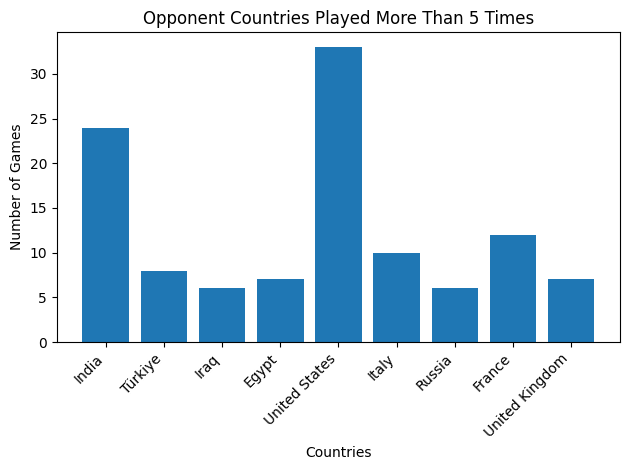

In [ ]:
print("")
# Print opponent countries played more than 5 times
print("\nOpponent Countries Played More Than 5 Times:")
filtered_opponent_countries = {country: count for country, count in opponent_countries.items() if count > 5}
for country, count in filtered_opponent_countries.items():
    print(f"   {country}: {count}")

print("")
# Visualize opponent countries played more than 5 times
if filtered_opponent_countries:
    plt.bar(filtered_opponent_countries.keys(), filtered_opponent_countries.values())
    plt.title("Opponent Countries Played More Than 5 Times")
    plt.xlabel("Countries")
    plt.ylabel("Number of Games")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



Average Accuracy as White: 72.67
Average Accuracy as Black: 73.07



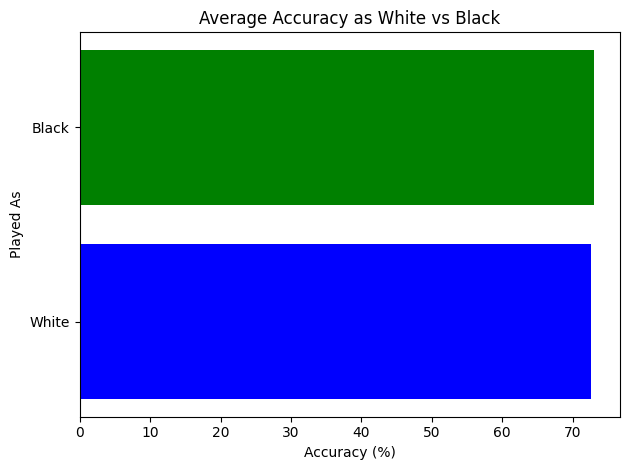

In [ ]:
print("")
print(f"Average Accuracy as White: {avg_white_accuracy:.2f}")
print(f"Average Accuracy as Black: {avg_black_accuracy:.2f}")
print("")

# Horizontal bar chart for accuracies as White and Black
accuracies = {
    "White": avg_white_accuracy,
    "Black": avg_black_accuracy
}
plt.barh(list(accuracies.keys()), list(accuracies.values()), color=['blue', 'green'])
plt.title("Average Accuracy as White vs Black")
plt.xlabel("Accuracy (%)")
plt.ylabel("Played As")
plt.tight_layout()
plt.show()

222 81 61 57 46
224 41 41 57 46


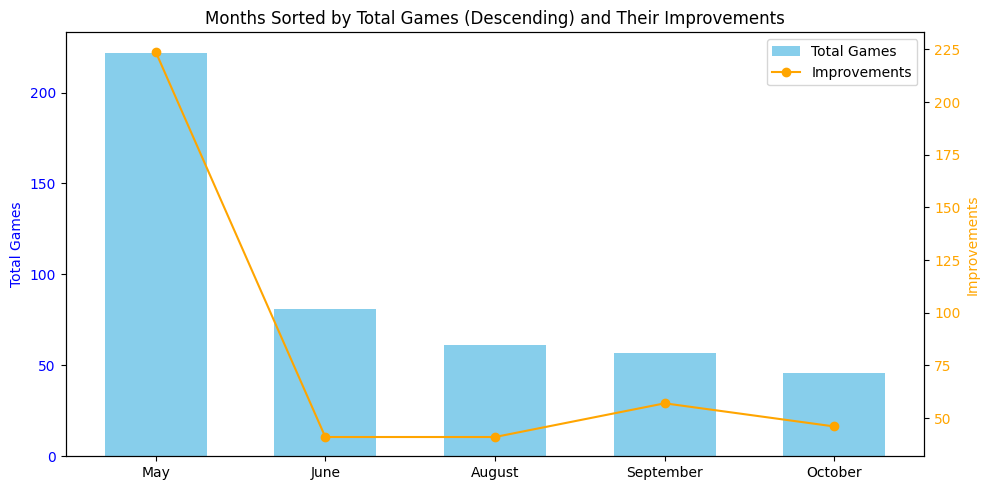

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

month_to_index = {5: 0, 6: 1, 8: 2, 9: 3, 10: 4}


month_input = int(month_input)


if month_input in month_to_index:
    index = month_to_index[month_input]  # Map month to index

    # Update the lists
    total_games[index] = played_as_black + played_as_white
    improvements[index] = last_rating - first_rating

    # Print updated results
    print(total_games[0], total_games[1], total_games[2], total_games[3], total_games[4])
    print(improvements[0], improvements[1], improvements[2], improvements[3], improvements[4])


# The months in the same order as your lists' indices
month_labels = ["May", "June", "August", "September", "October"]

# 1) Combine your month labels with total_games and improvements
data = list(zip(month_labels, total_games, improvements))

# 2) Sort by total games (index=1 in each tuple) in descending order
data.sort(key=lambda x: x[1], reverse=True)

# 3) Unzip the sorted data back into separate lists
sorted_months = [x[0] for x in data]
sorted_games = [x[1] for x in data]
sorted_improvements = [x[2] for x in data]

# 4) Create a dual-axis figure:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()  # Second y-axis sharing the same x-axis

# 5) Bar chart for total games on the primary axis
bar_width = 0.6
ax1.bar(sorted_months, sorted_games, width=bar_width, color='skyblue', label='Total Games')
ax1.set_ylabel("Total Games", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 6) Line plot for improvements on the secondary axis
ax2.plot(sorted_months, sorted_improvements, marker='o', color='orange', label='Improvements')
ax2.set_ylabel("Improvements", color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 7) Title and layout
plt.title("Months Sorted by Total Games (Descending) and Their Improvements")


lines_labels_1 = ax1.get_legend_handles_labels()
lines_labels_2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels_1[0] + lines_labels_2[0],
    lines_labels_1[1] + lines_labels_2[1],
    loc='upper right'
)

plt.tight_layout()
plt.show()



Games with less than 10 moves: 16
Games with 10-20 moves: 28
Games with 20-30 moves: 52
Games with 30-40 moves: 56
Games with more than 40 moves: 70
Total categorized games: 222
Total games: 222



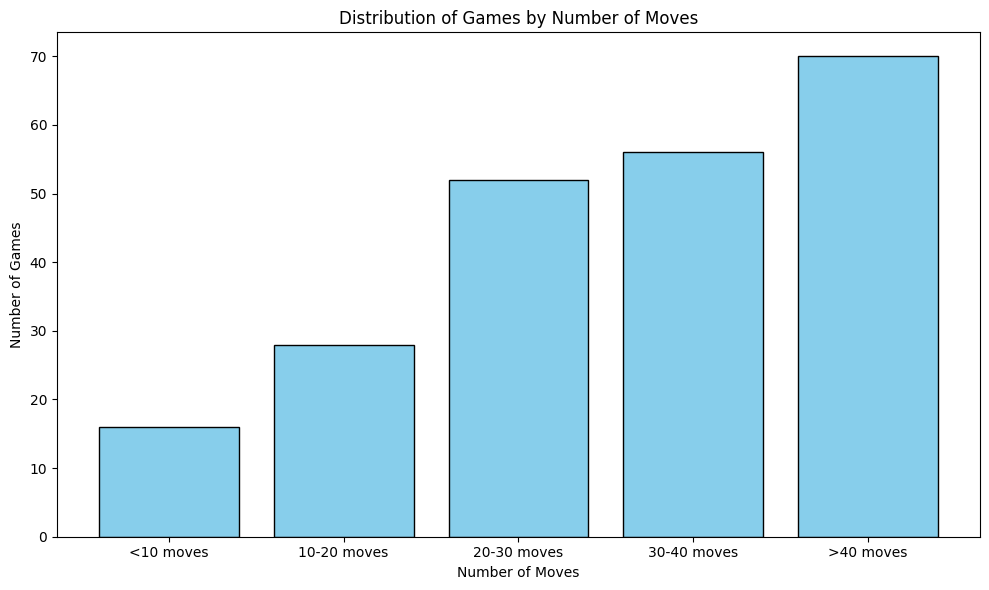

In [4]:
import requests
import matplotlib.pyplot as plt

# API URL
url = "https://api.chess.com/pub/player/xreadytodayalex/games/2024/05"

# Include User-Agent header to avoid 403 errors
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.0.0 Safari/537.36"
}

# Fetch data from the API
response = requests.get(url, headers=headers)

# Check if the response is successful
if response.status_code == 200:
    data = response.json()
    games = data.get("games", [])

    # List to store the number of moves for each game
    moves_count = []

    # Sequential game counter
    game_number = 1

    # Process each game
    for game in games:
        # Check if the game is ranked and rapid
        if game.get("rated") and game.get("time_class") == "rapid":
            # Extract the PGN
            pgn = game.get("pgn", "")

            # Find all move numbers (e.g., "1.", "2.")
            move_numbers = [item for item in pgn.split() if item.endswith(".")]

            # Calculate total moves
            if move_numbers:
                total_moves = int(move_numbers[-1].strip("."))
                moves_count.append(total_moves)

            else:
                moves_count.append(0)  # No moves found in the game


            # Increment the game number sequentially
            game_number += 1

    # Categorize games by number of moves
    less_than_10 = len([moves for moves in moves_count if moves < 10])
    between_10_and_20 = len([moves for moves in moves_count if 10 <= moves < 20])
    between_20_and_30 = len([moves for moves in moves_count if 20 <= moves < 30])
    between_30_and_40 = len([moves for moves in moves_count if 30 <= moves < 40])
    more_than_40 = len([moves for moves in moves_count if moves >= 40])

    # Total games to ensure categorization consistency
    total_categorized = (
        less_than_10 + between_10_and_20 + between_20_and_30 +
        between_30_and_40 + more_than_40
    )

    # Print categorized results
    print(f"Games with less than 10 moves: {less_than_10}")
    print(f"Games with 10-20 moves: {between_10_and_20}")
    print(f"Games with 20-30 moves: {between_20_and_30}")
    print(f"Games with 30-40 moves: {between_30_and_40}")
    print(f"Games with more than 40 moves: {more_than_40}")
    print(f"Total categorized games: {total_categorized}")
    print(f"Total games: {len(moves_count)}")

    print("")

    # Create histogram data
    categories = [
        "<10 moves", "10-20 moves", "20-30 moves", "30-40 moves", ">40 moves"
    ]
    counts = [
        less_than_10, between_10_and_20, between_20_and_30,
        between_30_and_40, more_than_40
    ]

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color='skyblue', edgecolor='black')
    plt.title("Distribution of Games by Number of Moves")
    plt.xlabel("Number of Moves")
    plt.ylabel("Number of Games")
    plt.tight_layout()
    plt.show()

else:
    print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")


Categorized Game Counts:
Games starting before 6: 12
Games starting between 6 and 12: 70
Games starting between 12 and 18: 75
Games starting after 18: 65
 


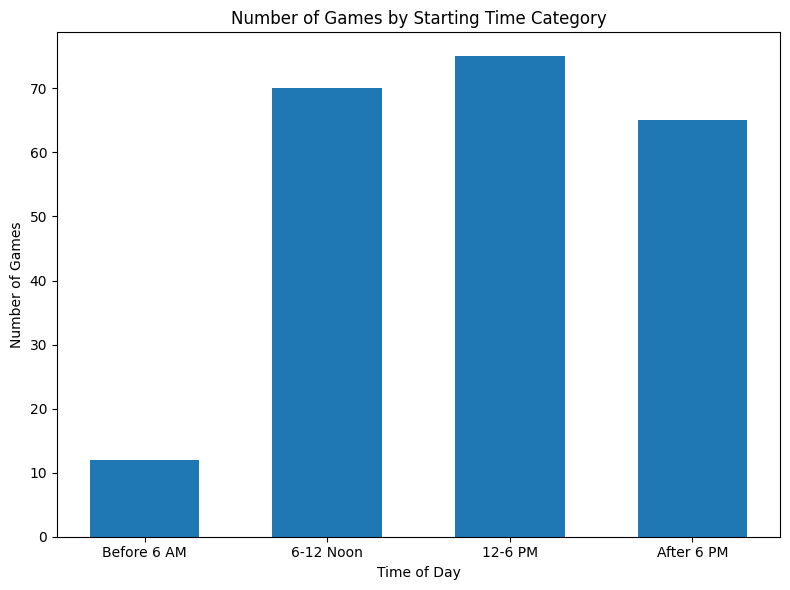

In [3]:
import requests
from datetime import datetime

# API URL
url = "https://api.chess.com/pub/player/xreadytodayalex/games/2024/05"

# Include User-Agent header to avoid 403 errors
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.0.0 Safari/537.36"
}

# Fetch data from the API
response = requests.get(url, headers=headers)

# Check if the response is successful
if response.status_code == 200:
    data = response.json()
    games = data.get("games", [])

    # Lists to categorize games by starting time
    before_6 = []
    between_6_and_12 = []
    between_12_and_18 = []
    after_18 = []

    # Sequential game counter
    game_number = 1

    # Process each game
    for game in games:
        # Check if the game is rated and rapid
        if game.get("rated") and game.get("time_class") == "rapid":
            # Extract the PGN
            pgn = game.get("pgn", "")

            # Find the starting time in the PGN
            start_time_line = [line for line in pgn.splitlines() if line.startswith("[StartTime")]
            if start_time_line:
                start_time = start_time_line[0].split(" ")[1].strip("\"]")

                # Parse the time and categorize
                hour = int(start_time.split(":")[0])
                if hour < 6:
                    before_6.append(game_number)
                elif 6 <= hour < 12:
                    between_6_and_12.append(game_number)
                elif 12 <= hour < 18:
                    between_12_and_18.append(game_number)
                else:
                    after_18.append(game_number)


                # Increment the game number
                game_number += 1

    # Print the categorized results
    print("\nCategorized Game Counts:")
    print(f"Games starting before 6: {len(before_6)}")
    print(f"Games starting between 6 and 12: {len(between_6_and_12)}")
    print(f"Games starting between 12 and 18: {len(between_12_and_18)}")
    print(f"Games starting after 18: {len(after_18)}")

else:
    print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")

print(" ")
import matplotlib.pyplot as plt

# Assuming these lists are already created and populated with the appropriate data
time_categories = ['Before 6 AM', '6-12 Noon', '12-6 PM', 'After 6 PM']
counts = [
    len(before_6),
    len(between_6_and_12),
    len(between_12_and_18),
    len(after_18)
]

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(time_categories, counts, width=0.6)

# Add titles and labels
plt.title('Number of Games by Starting Time Category')
plt.xlabel('Time of Day')
plt.ylabel('Number of Games')

# Show the histogram
plt.tight_layout()
plt.show()
